# Looking at mask predictions

Running validation data through saved model to look at masks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

sys.path.append('../src')
from UNet2D import UNet2D
from UNetMultiTask import UNetMultiTask
from datasets import MycetomaDataset
from metrics import batch_dice_coeff, bce_dice_loss, dice_coefficient
from postprocessing import threshold_mask, post_process_binary_mask

In [2]:
DATA_DIR = '../data'

In [3]:
train_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/corrected_training_dataset/**/*.jpg')])
val_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/corrected_validation_dataset/**/*.jpg')])

problem_val_paths = np.array(['corrected_validation_dataset/FM/FM10_1'])
val_paths = np.setdiff1d(val_paths, problem_val_paths)

print(f"Train length: {len(train_paths)}")
print(f"Val length: {len(val_paths)}")

Train length: 537
Val length: 86


In [4]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
train_dataset = MycetomaDataset(train_paths, DATA_DIR)
val_dataset = MycetomaDataset(val_paths, DATA_DIR)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [7]:
# Plot an image, along with prediction and ground truth
def plot_image(im, pred, gt):

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))

    ax[0].imshow(im)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(pred)
    ax[1].set_title('prediction')
    ax[1].axis('off')

    ax[2].imshow(gt)
    ax[2].set_title('GT')
    ax[2].axis('off')

    plt.show()

In [21]:
# Create and load model save
model = UNetMultiTask(3, 1, 8)
state_dict = torch.load('../model_saves/multitask_firstgo_best_model.pth', map_location=torch.device(device))

# Sometimes, the model dictionary keys contain 'module.' prefix which we don't want
remove_prefix = True

if remove_prefix:
    remove_prefix = 'module.'
    state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model = model.to(device)

model.eval();

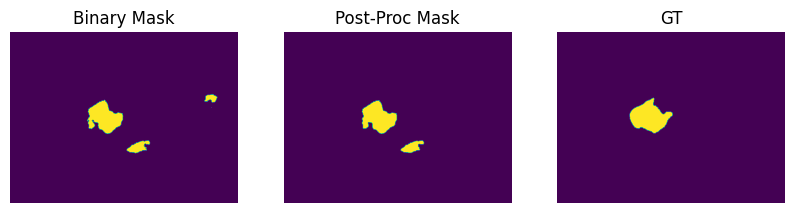

Classification prediction: 0.9910026788711548, GT: 1
Dice score before postproc: 0.7662314176559448 vs after: 0.7983431816101074


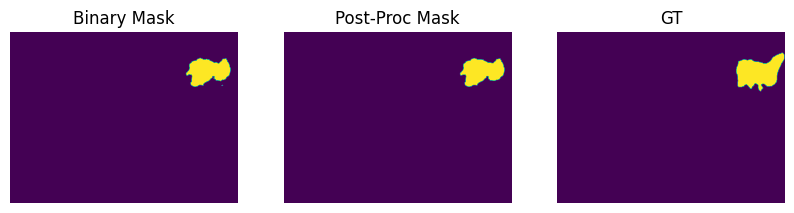

Classification prediction: 0.9988927245140076, GT: 1
Dice score before postproc: 0.8203974366188049 vs after: 0.819911539554596


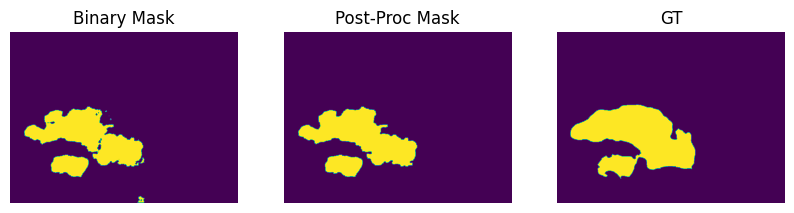

Classification prediction: 0.9999691247940063, GT: 1
Dice score before postproc: 0.84305739402771 vs after: 0.8478618264198303


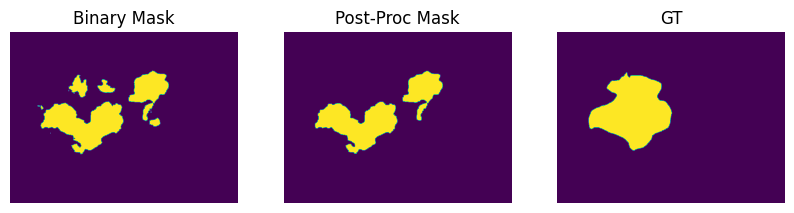

Classification prediction: 0.9996328353881836, GT: 1
Dice score before postproc: 0.6637082099914551 vs after: 0.6062471866607666


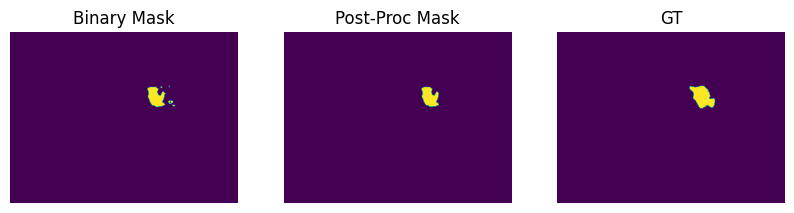

Classification prediction: 0.9853772521018982, GT: 1
Dice score before postproc: 0.7480325698852539 vs after: 0.7678129076957703


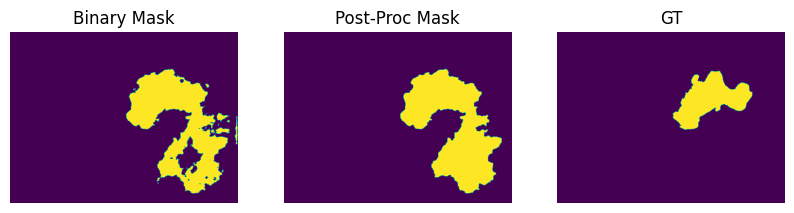

Classification prediction: 0.9999889135360718, GT: 1
Dice score before postproc: 0.5620200634002686 vs after: 0.5426952838897705


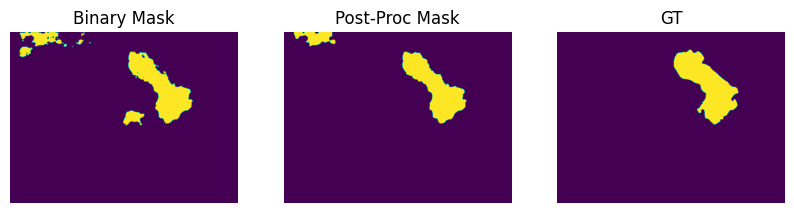

Classification prediction: 0.9972488284111023, GT: 1
Dice score before postproc: 0.7665833830833435 vs after: 0.8191099762916565


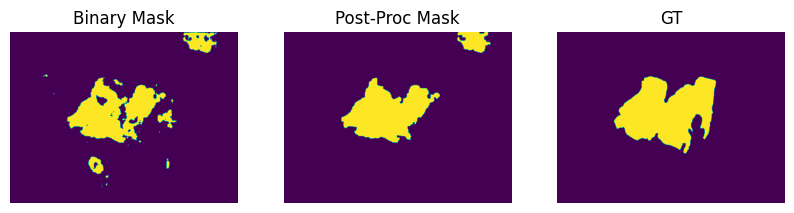

Classification prediction: 0.9999936819076538, GT: 1
Dice score before postproc: 0.7272931933403015 vs after: 0.772672176361084


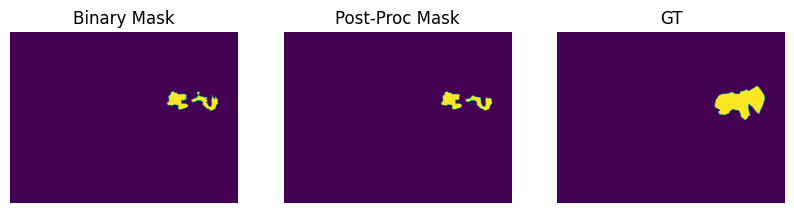

Classification prediction: 0.9901012182235718, GT: 1
Dice score before postproc: 0.5243743062019348 vs after: 0.5053795576095581


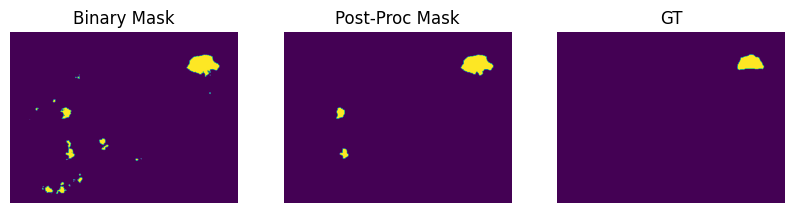

Classification prediction: 0.10432029515504837, GT: 1
Dice score before postproc: 0.5661304593086243 vs after: 0.6934136152267456


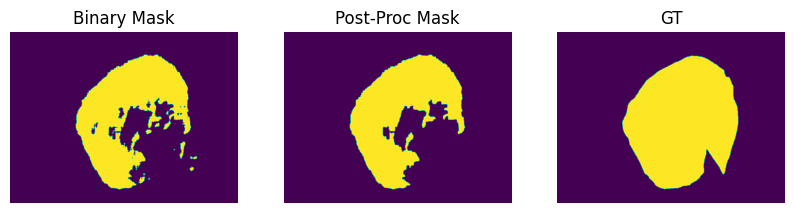

Classification prediction: 0.9998795986175537, GT: 1
Dice score before postproc: 0.8092007637023926 vs after: 0.8052492141723633


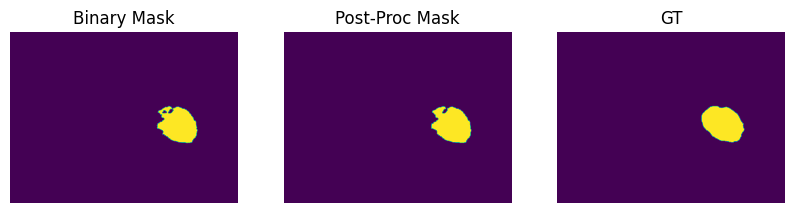

Classification prediction: 0.9829059839248657, GT: 1
Dice score before postproc: 0.9211999773979187 vs after: 0.9253543615341187


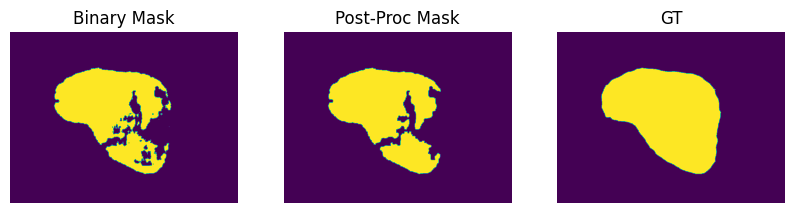

Classification prediction: 0.9995856881141663, GT: 1
Dice score before postproc: 0.8631262183189392 vs after: 0.8702040910720825


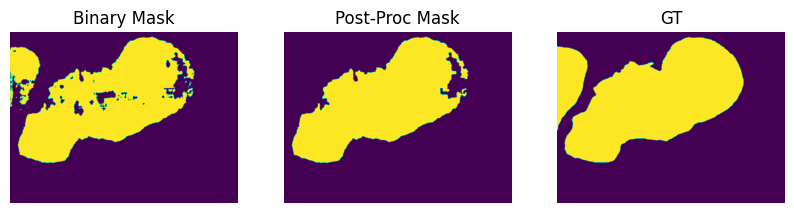

Classification prediction: 0.9858847260475159, GT: 1
Dice score before postproc: 0.9184062480926514 vs after: 0.8868900537490845


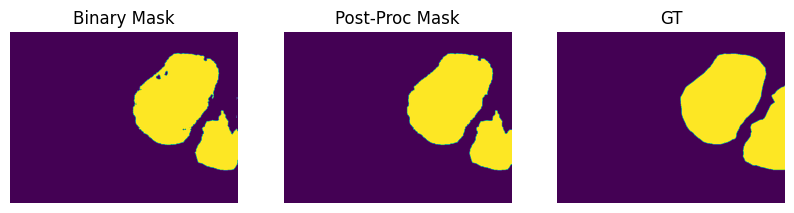

Classification prediction: 0.23439078032970428, GT: 1
Dice score before postproc: 0.9450075030326843 vs after: 0.9465155005455017


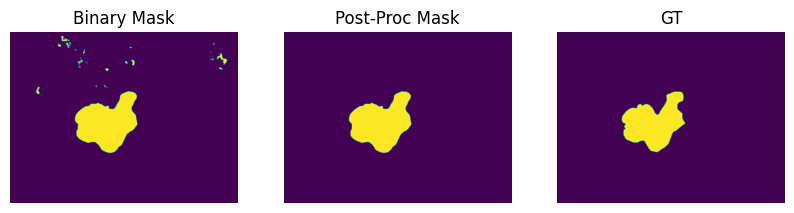

Classification prediction: 0.9999865293502808, GT: 1
Dice score before postproc: 0.9300348162651062 vs after: 0.9592717289924622


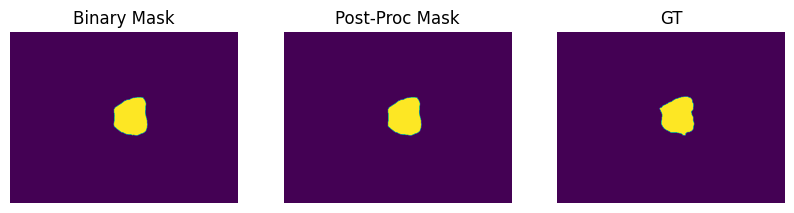

Classification prediction: 0.9826349020004272, GT: 1
Dice score before postproc: 0.9609586000442505 vs after: 0.9611874222755432


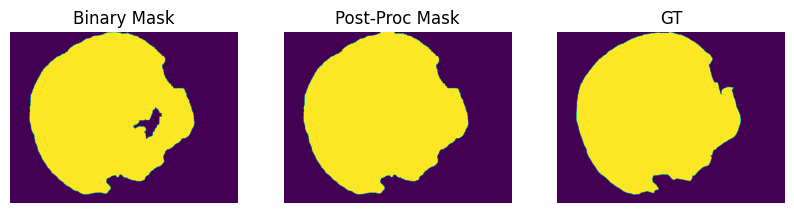

Classification prediction: 1.0, GT: 1
Dice score before postproc: 0.9820510149002075 vs after: 0.9906162619590759


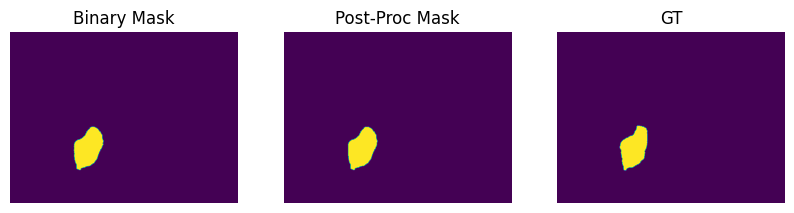

Classification prediction: 0.97867351770401, GT: 1
Dice score before postproc: 0.9359404444694519 vs after: 0.9367483258247375


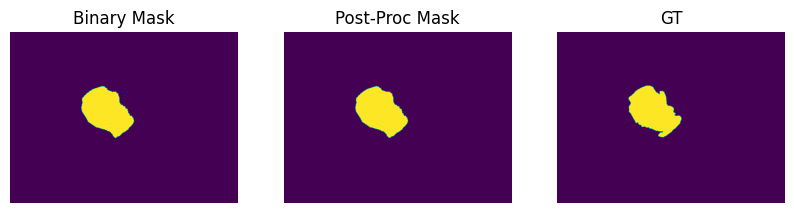

Classification prediction: 0.9923492670059204, GT: 1
Dice score before postproc: 0.9709364175796509 vs after: 0.9709072113037109


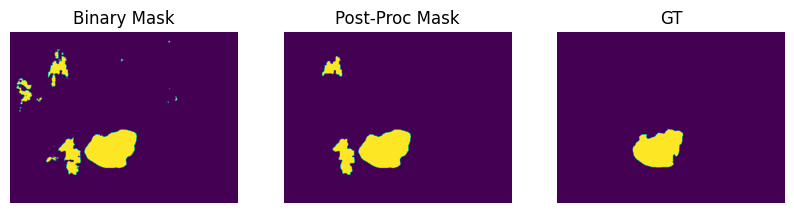

Classification prediction: 0.9967345595359802, GT: 1
Dice score before postproc: 0.7251037359237671 vs after: 0.7855403423309326


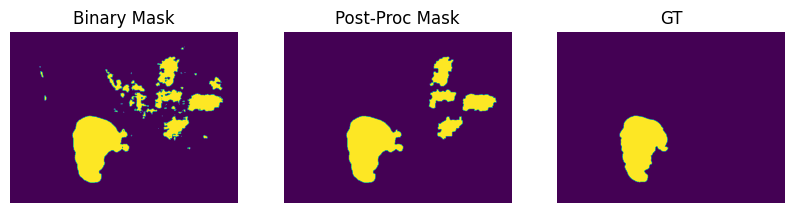

Classification prediction: 0.999674916267395, GT: 1
Dice score before postproc: 0.646065354347229 vs after: 0.7116354703903198


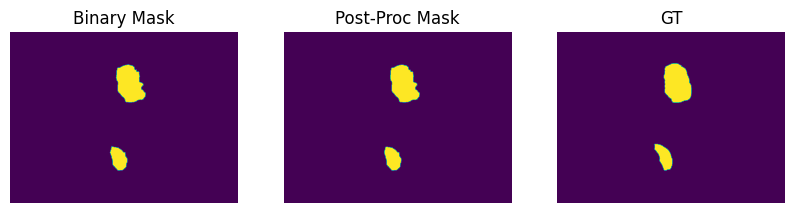

Classification prediction: 0.9435592889785767, GT: 1
Dice score before postproc: 0.9145677089691162 vs after: 0.9140556454658508


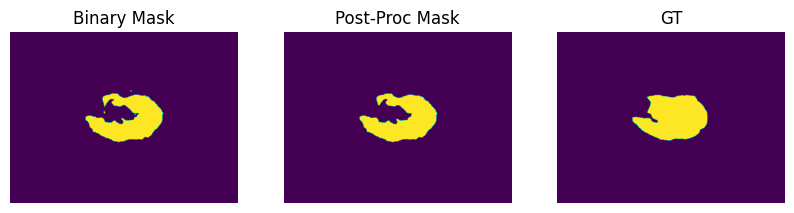

Classification prediction: 0.9463315010070801, GT: 1
Dice score before postproc: 0.8529627323150635 vs after: 0.8518133759498596


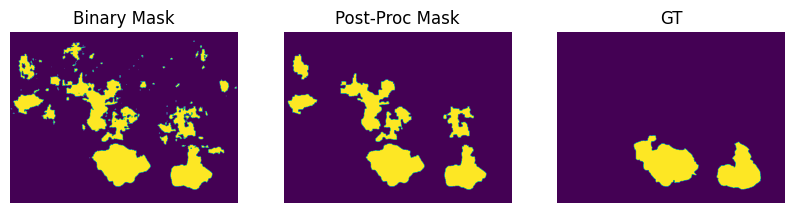

Classification prediction: 0.9869376420974731, GT: 1
Dice score before postproc: 0.5453078746795654 vs after: 0.6070210933685303


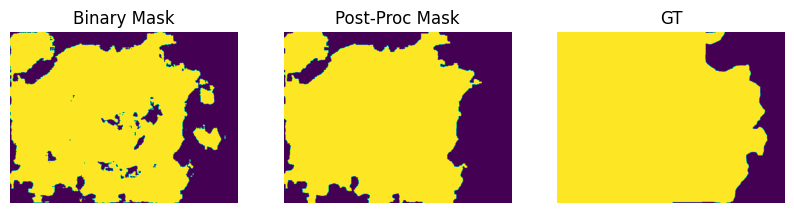

Classification prediction: 1.0, GT: 1
Dice score before postproc: 0.8839640617370605 vs after: 0.8849465250968933


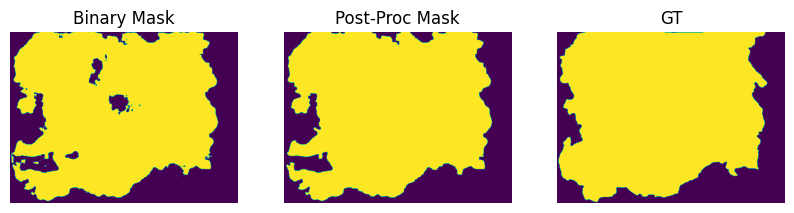

Classification prediction: 1.0, GT: 1
Dice score before postproc: 0.9532102942466736 vs after: 0.9629011154174805


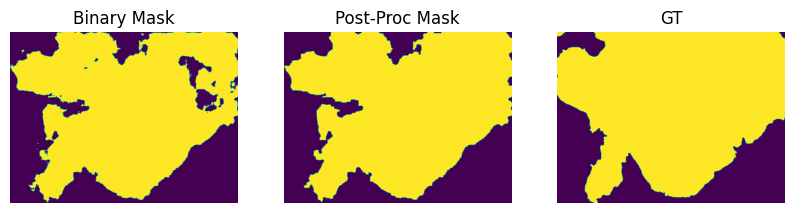

Classification prediction: 1.0, GT: 1
Dice score before postproc: 0.9240472316741943 vs after: 0.9397329688072205


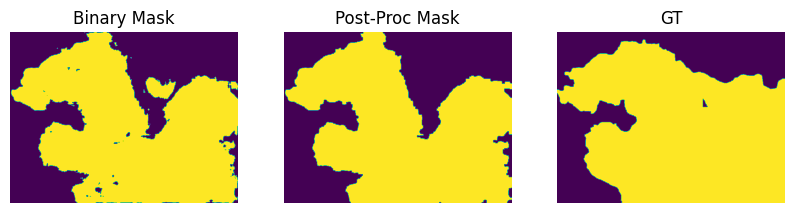

Classification prediction: 1.0, GT: 1
Dice score before postproc: 0.9288582801818848 vs after: 0.9220804572105408


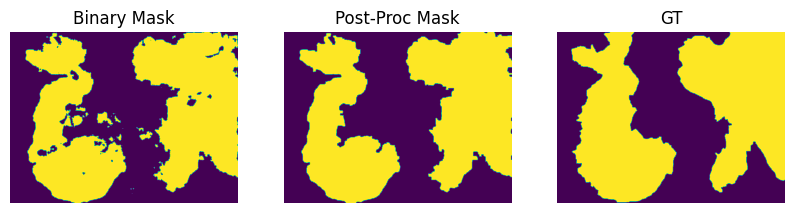

Classification prediction: 1.0, GT: 1
Dice score before postproc: 0.9006383419036865 vs after: 0.9111477732658386


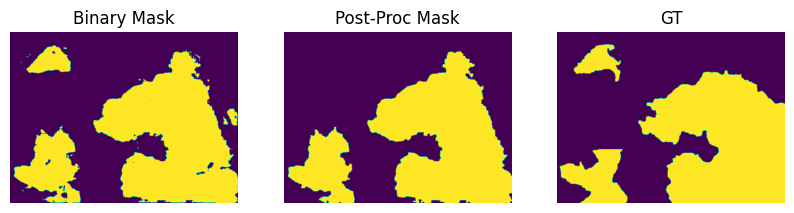

Classification prediction: 1.0, GT: 1
Dice score before postproc: 0.8840656280517578 vs after: 0.8596493601799011


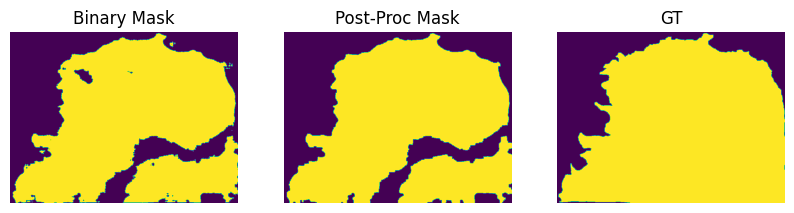

Classification prediction: 1.0, GT: 1
Dice score before postproc: 0.9285733103752136 vs after: 0.9319373369216919


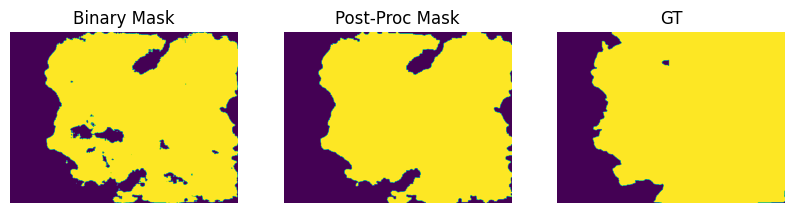

Classification prediction: 1.0, GT: 1
Dice score before postproc: 0.9365953803062439 vs after: 0.9504203200340271


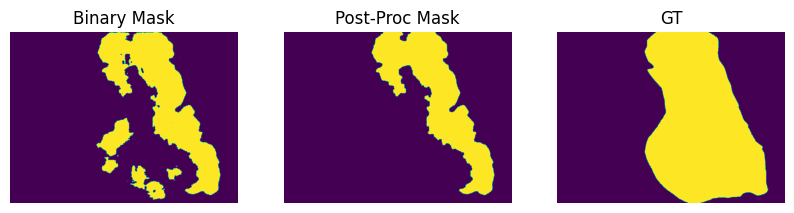

Classification prediction: 0.9999974966049194, GT: 1
Dice score before postproc: 0.7181261777877808 vs after: 0.6386873126029968


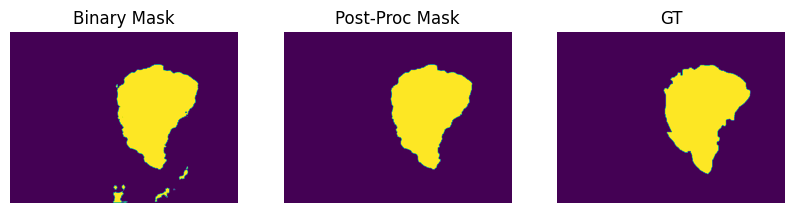

Classification prediction: 0.9999856948852539, GT: 1
Dice score before postproc: 0.9348912835121155 vs after: 0.9524514675140381


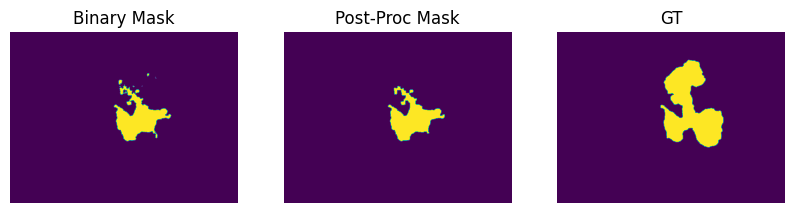

Classification prediction: 0.14180953800678253, GT: 0
Dice score before postproc: 0.5860764980316162 vs after: 0.5750758647918701


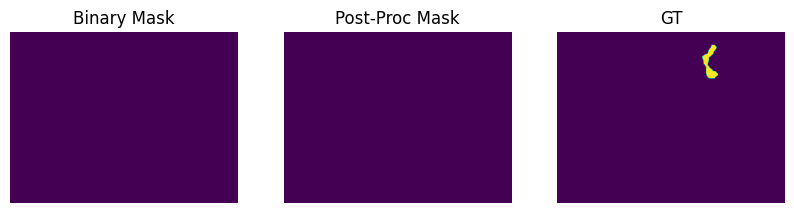

Classification prediction: 0.8151546120643616, GT: 0
Dice score before postproc: 0.0 vs after: 0.0


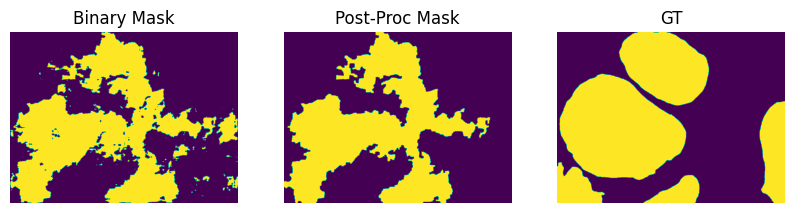

Classification prediction: 2.6786161470226943e-05, GT: 0
Dice score before postproc: 0.666702389717102 vs after: 0.6499003767967224


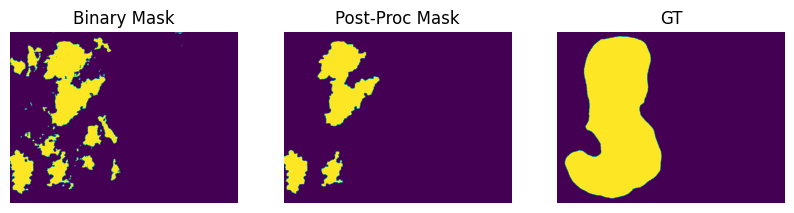

Classification prediction: 0.011231076903641224, GT: 0
Dice score before postproc: 0.4946436583995819 vs after: 0.4629991948604584


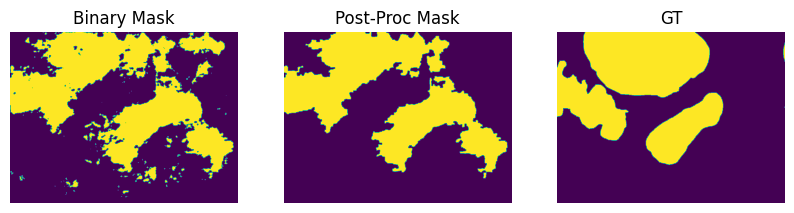

Classification prediction: 4.5179680455476046e-05, GT: 0
Dice score before postproc: 0.6939013600349426 vs after: 0.7341568470001221


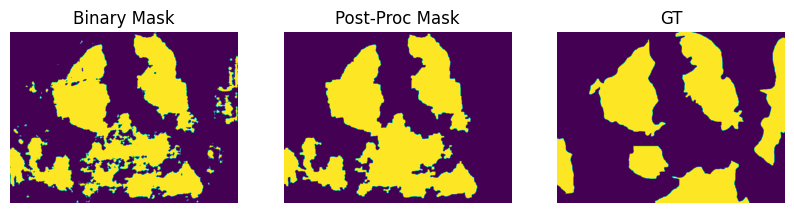

Classification prediction: 0.00019318186969030648, GT: 0
Dice score before postproc: 0.6930233836174011 vs after: 0.669835090637207


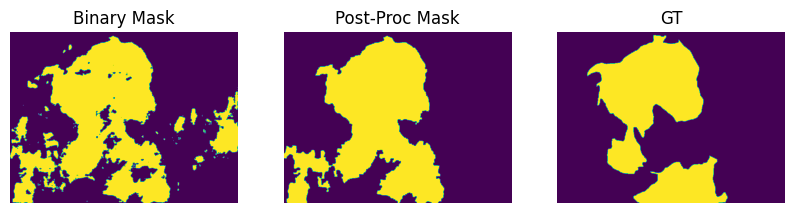

Classification prediction: 4.138012445764616e-05, GT: 0
Dice score before postproc: 0.7298796772956848 vs after: 0.7981948852539062


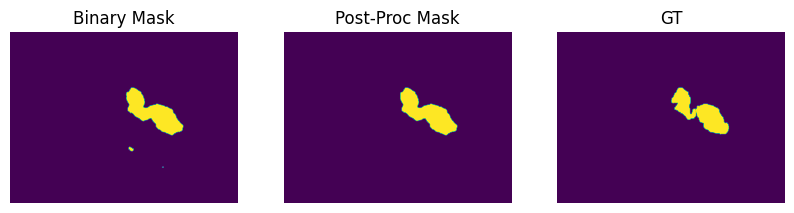

Classification prediction: 0.317454993724823, GT: 0
Dice score before postproc: 0.922648012638092 vs after: 0.9292529225349426


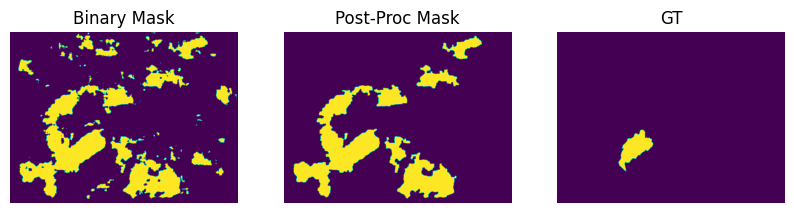

Classification prediction: 0.04140472784638405, GT: 0
Dice score before postproc: 0.15504740178585052 vs after: 0.18546102941036224


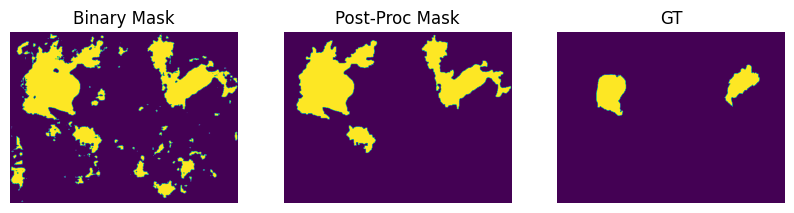

Classification prediction: 0.009088140912353992, GT: 0
Dice score before postproc: 0.3401954174041748 vs after: 0.415147066116333


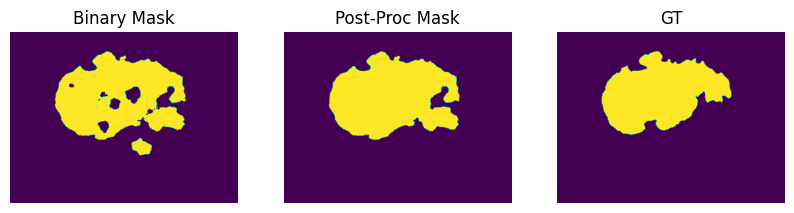

Classification prediction: 1.5969703781593125e-06, GT: 0
Dice score before postproc: 0.8592662811279297 vs after: 0.8906049728393555


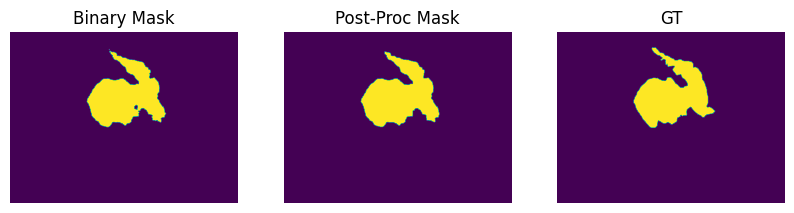

Classification prediction: 0.005638455972075462, GT: 0
Dice score before postproc: 0.9402088522911072 vs after: 0.9417893290519714


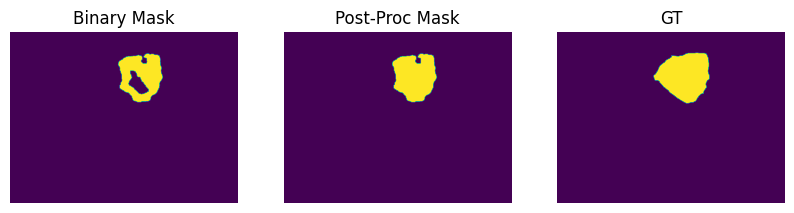

Classification prediction: 0.023323222994804382, GT: 0
Dice score before postproc: 0.8178447484970093 vs after: 0.8965017795562744


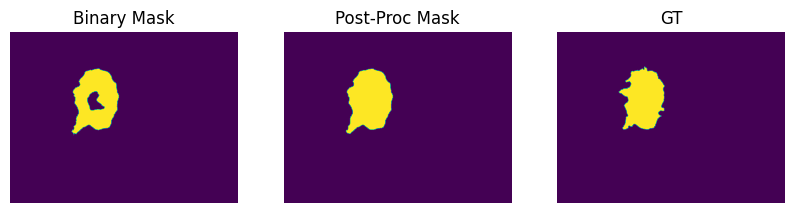

Classification prediction: 0.008171751163899899, GT: 0
Dice score before postproc: 0.886800229549408 vs after: 0.9375908970832825


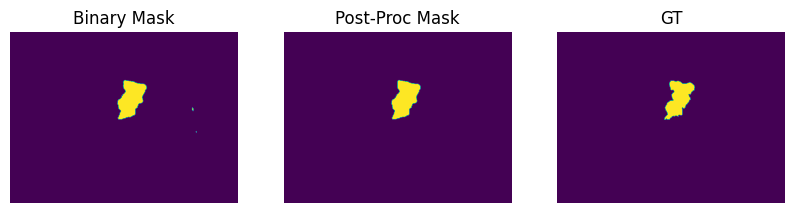

Classification prediction: 0.06487945467233658, GT: 0
Dice score before postproc: 0.9173925518989563 vs after: 0.9202302694320679


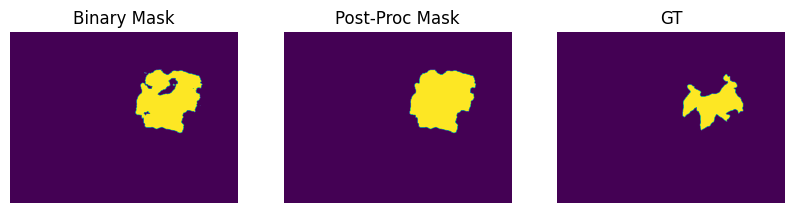

Classification prediction: 0.004758366849273443, GT: 0
Dice score before postproc: 0.7042295336723328 vs after: 0.6799964308738708


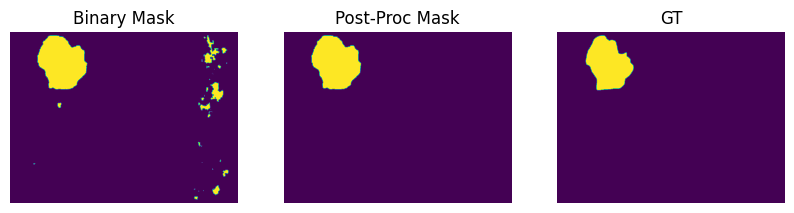

Classification prediction: 0.05213071033358574, GT: 0
Dice score before postproc: 0.8237815499305725 vs after: 0.9309134483337402


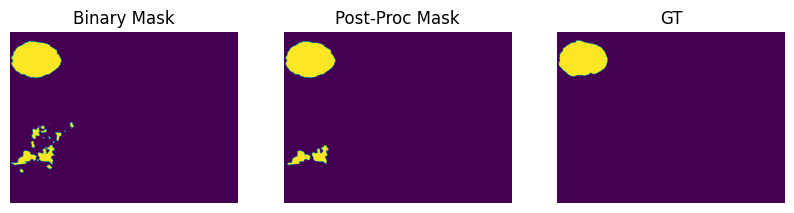

Classification prediction: 0.9150874018669128, GT: 0
Dice score before postproc: 0.8164907097816467 vs after: 0.8663619756698608


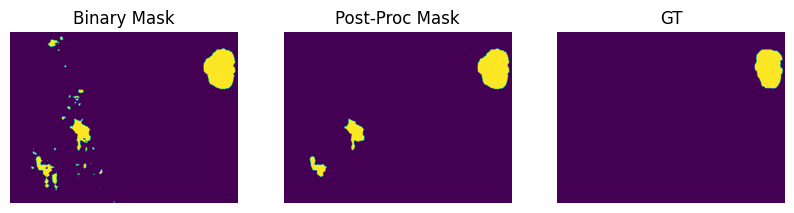

Classification prediction: 0.20849280059337616, GT: 0
Dice score before postproc: 0.6636486053466797 vs after: 0.7370373010635376


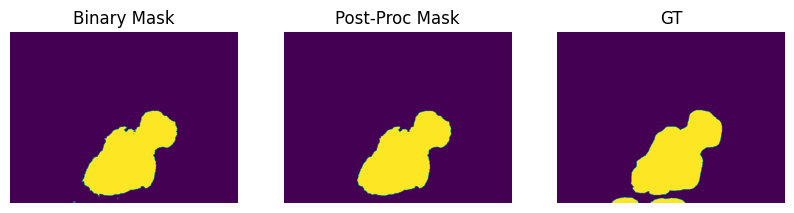

Classification prediction: 0.09624316543340683, GT: 0
Dice score before postproc: 0.946617841720581 vs after: 0.9467043280601501


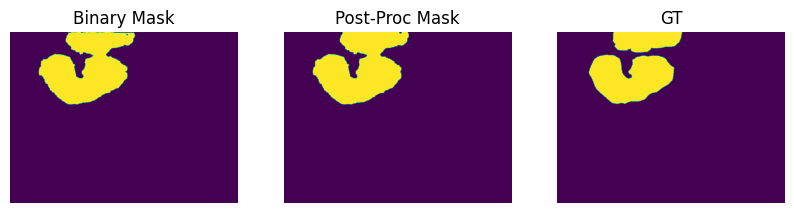

Classification prediction: 0.20654688775539398, GT: 0
Dice score before postproc: 0.9558243751525879 vs after: 0.958242654800415


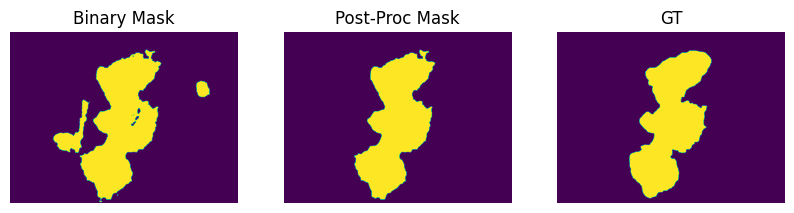

Classification prediction: 0.0015830465126782656, GT: 0
Dice score before postproc: 0.8955665230751038 vs after: 0.9523076415061951


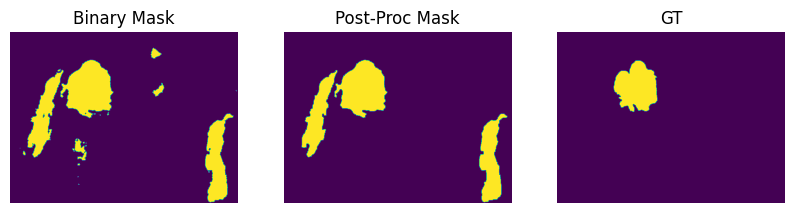

Classification prediction: 0.76712566614151, GT: 0
Dice score before postproc: 0.4963507354259491 vs after: 0.5203721523284912


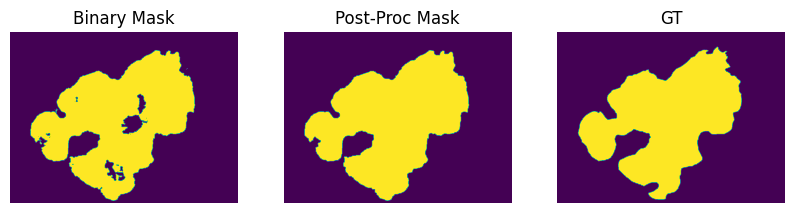

Classification prediction: 0.0007135015330277383, GT: 0
Dice score before postproc: 0.9425089359283447 vs after: 0.9647999405860901


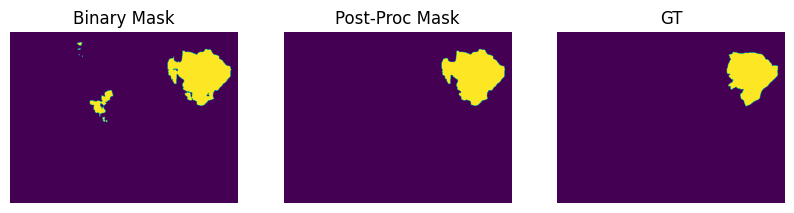

Classification prediction: 0.012467165477573872, GT: 0
Dice score before postproc: 0.8352053165435791 vs after: 0.8862833380699158


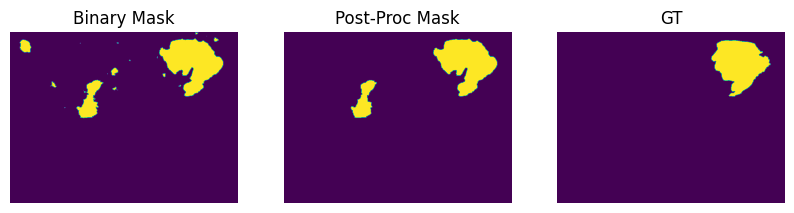

Classification prediction: 0.006861785426735878, GT: 0
Dice score before postproc: 0.7802996635437012 vs after: 0.8162096738815308


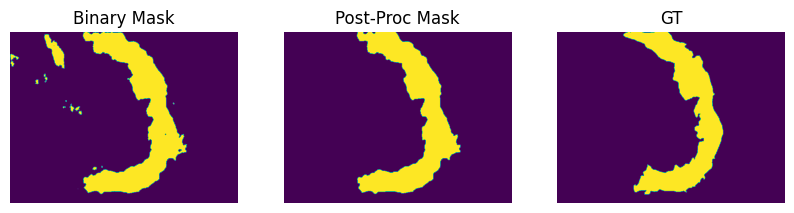

Classification prediction: 1.4350731589729548e-06, GT: 0
Dice score before postproc: 0.8841546773910522 vs after: 0.9176413416862488


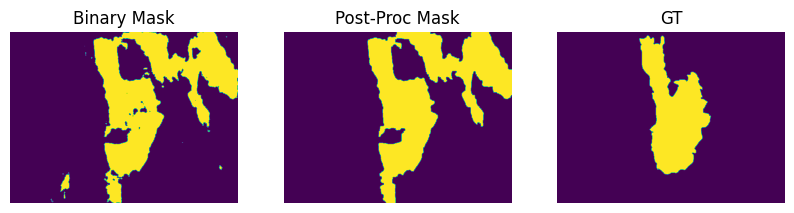

Classification prediction: 6.413170883234898e-09, GT: 0
Dice score before postproc: 0.6312686204910278 vs after: 0.6372839212417603


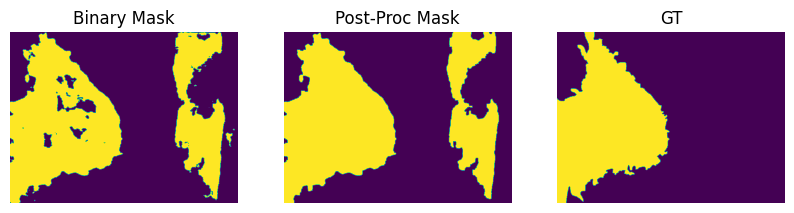

Classification prediction: 4.933560070891074e-13, GT: 0
Dice score before postproc: 0.7694904208183289 vs after: 0.7983971834182739


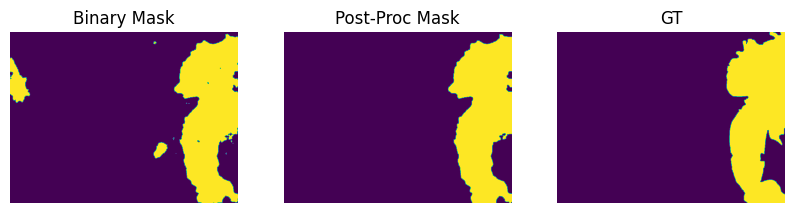

Classification prediction: 7.854361570025503e-07, GT: 0
Dice score before postproc: 0.9192936420440674 vs after: 0.9601312875747681


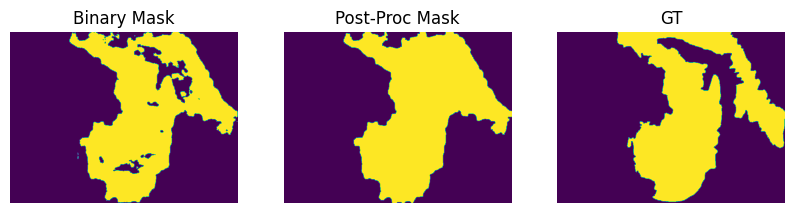

Classification prediction: 1.058493028470442e-12, GT: 0
Dice score before postproc: 0.9033046364784241 vs after: 0.8848831653594971


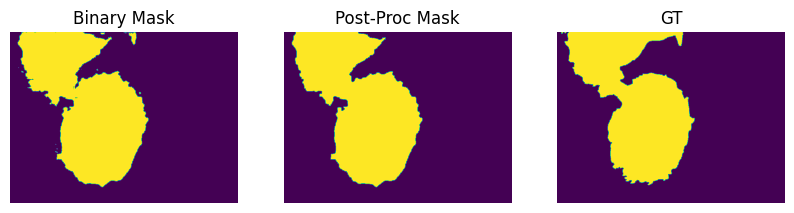

Classification prediction: 3.193646307408926e-07, GT: 0
Dice score before postproc: 0.9411327242851257 vs after: 0.9395118355751038


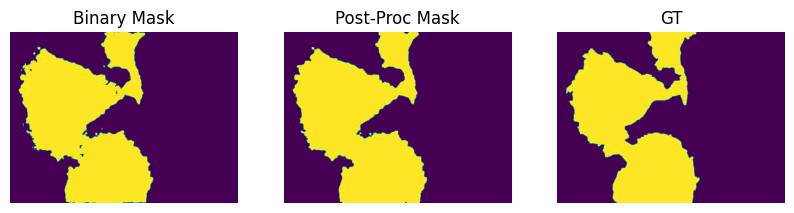

Classification prediction: 5.122369373111724e-08, GT: 0
Dice score before postproc: 0.9449849128723145 vs after: 0.9473068118095398


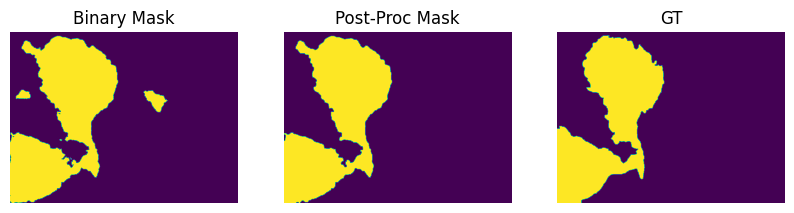

Classification prediction: 1.2929432386954431e-06, GT: 0
Dice score before postproc: 0.9297582507133484 vs after: 0.9485803842544556


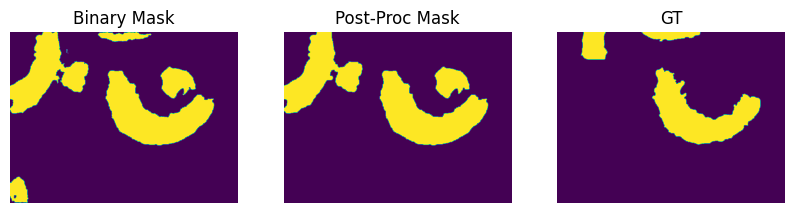

Classification prediction: 7.166170234995661e-07, GT: 0
Dice score before postproc: 0.6916150450706482 vs after: 0.6847184896469116


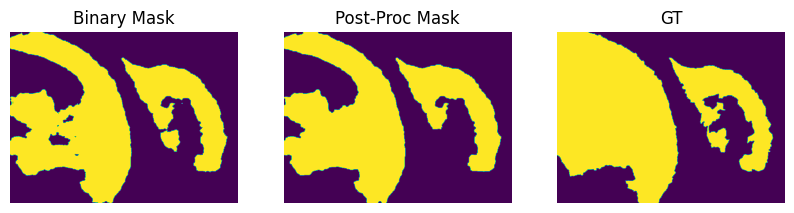

Classification prediction: 4.6303079426213145e-11, GT: 0
Dice score before postproc: 0.8810502290725708 vs after: 0.8797027468681335


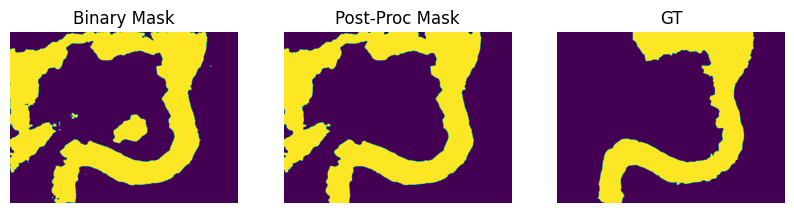

Classification prediction: 2.4233978712651094e-10, GT: 0
Dice score before postproc: 0.7564361095428467 vs after: 0.7801010608673096


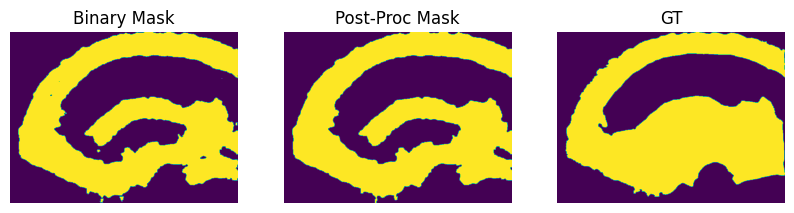

Classification prediction: 2.047774317194377e-14, GT: 0
Dice score before postproc: 0.8952718377113342 vs after: 0.8953021168708801


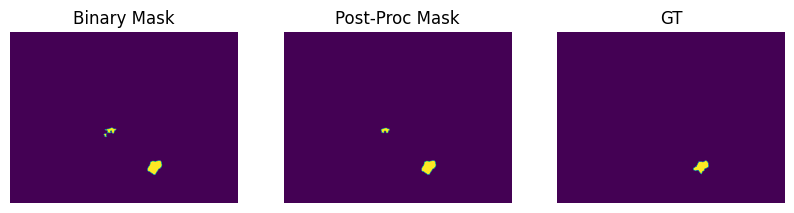

Classification prediction: 0.45897746086120605, GT: 0
Dice score before postproc: 0.7545428276062012 vs after: 0.7834184169769287


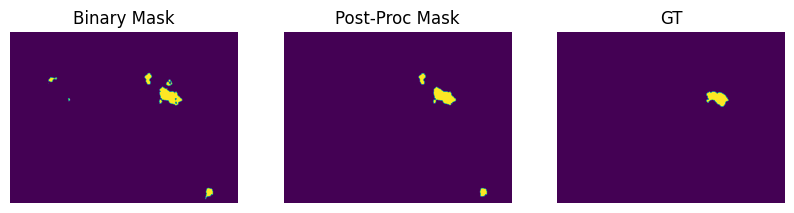

Classification prediction: 0.13610592484474182, GT: 0
Dice score before postproc: 0.6331544518470764 vs after: 0.6952117681503296


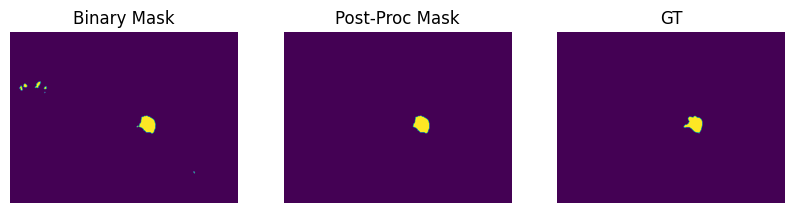

Classification prediction: 0.1310482770204544, GT: 0
Dice score before postproc: 0.8270538449287415 vs after: 0.9136410355567932


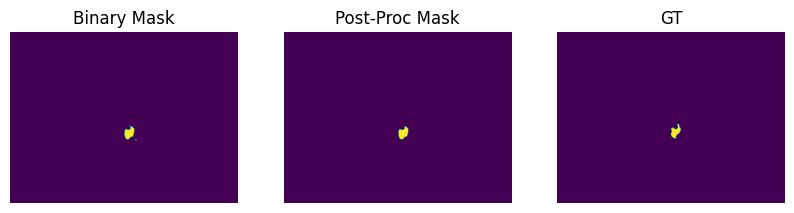

Classification prediction: 0.2340986281633377, GT: 0
Dice score before postproc: 0.7725024819374084 vs after: 0.7782805562019348


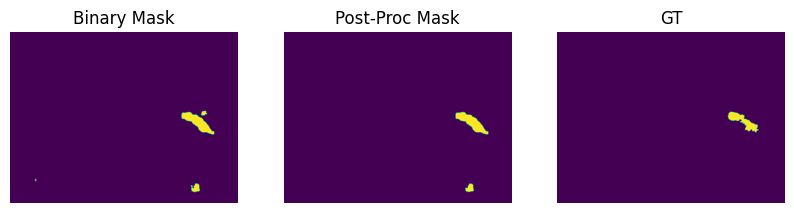

Classification prediction: 0.08818505704402924, GT: 0
Dice score before postproc: 0.7227003574371338 vs after: 0.7545787692070007


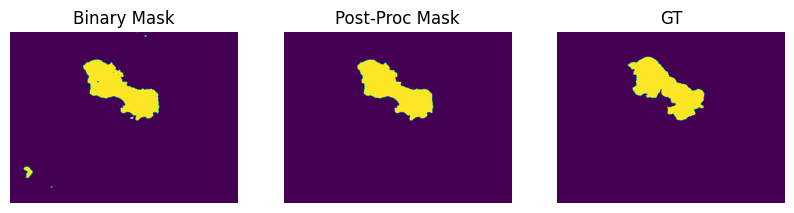

Classification prediction: 0.0017295378493145108, GT: 0
Dice score before postproc: 0.8774566650390625 vs after: 0.8896206021308899


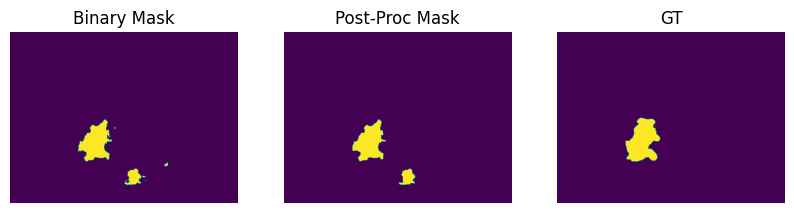

Classification prediction: 0.11366032063961029, GT: 0
Dice score before postproc: 0.7793470025062561 vs after: 0.7838717699050903


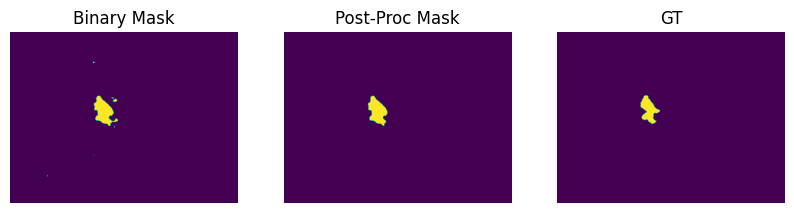

Classification prediction: 0.8535856604576111, GT: 0
Dice score before postproc: 0.8101266026496887 vs after: 0.8418917059898376


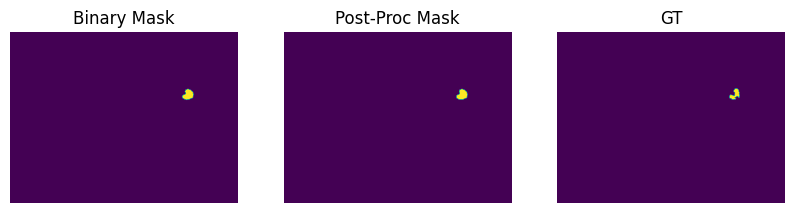

Classification prediction: 0.5580006241798401, GT: 0
Dice score before postproc: 0.7824601531028748 vs after: 0.7878440618515015


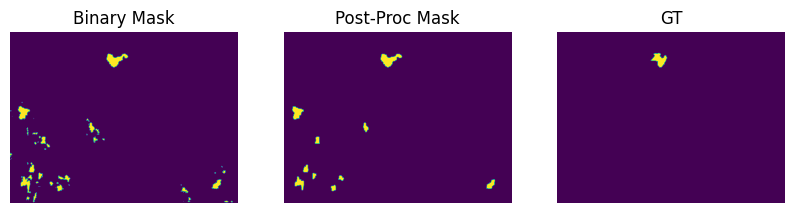

Classification prediction: 0.853445827960968, GT: 0
Dice score before postproc: 0.25035330653190613 vs after: 0.32854101061820984


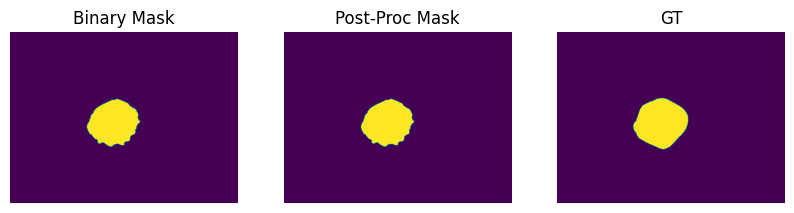

Classification prediction: 0.002189110731706023, GT: 0
Dice score before postproc: 0.940559446811676 vs after: 0.9405517578125


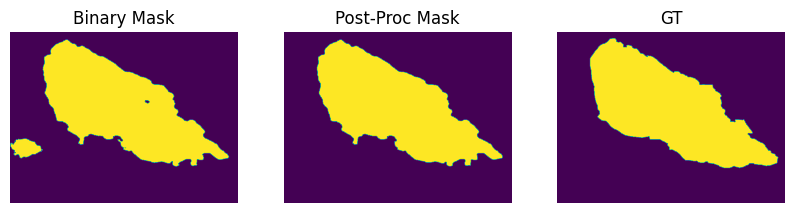

Classification prediction: 2.776066321263926e-10, GT: 0
Dice score before postproc: 0.9503663182258606 vs after: 0.9664434790611267


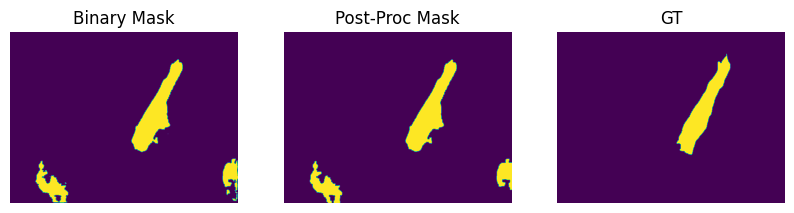

Classification prediction: 0.5304555892944336, GT: 0
Dice score before postproc: 0.7061644792556763 vs after: 0.7105522751808167
Av. dice score before preproc:  0.7839578038818625 vs post:  0.8019114994378977


In [20]:
# Put validation data through, plotting image, prediction, ground truth each time
from tqdm import tqdm

threshold = 0.5
dice_coeff = 0.0
post_dice_coeff = 0.0
gts = []
preds = []
n = 0

# Perform loop without computing gradients
with torch.no_grad():
    for idx, (inputs, targets, labels) in enumerate(val_loader):
        
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs, class_out = model(inputs)

        dice_coeff += batch_dice_coeff(outputs>threshold, targets).detach().cpu().numpy()
        n += 1

        im = inputs[0].detach().cpu().permute(1,2,0).numpy()
        pred = threshold_mask(outputs[0][0].detach().cpu().numpy())
        gt = targets[0][0].detach().cpu().numpy()

        #plot_image(im, pred, gt)
        dice = dice_coefficient(torch.from_numpy(pred).float(), torch.from_numpy(gt).float())

        # Post-process mask
        post_proc_mask = np.clip(post_process_binary_mask(pred, threshold_fraction=0.1), 0, 1)

        post_proc_dice = dice_coefficient(torch.from_numpy(post_proc_mask).float(), torch.from_numpy(gt).float())

        post_dice_coeff += post_proc_dice

        gts.append(labels.item())
        preds.append(class_out.squeeze().item())
        
        # Plot prediction before and after processing
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))
        ax[0].imshow(pred)
        ax[0].set_title('Binary Mask')
        ax[0].axis('off')

        ax[1].imshow(post_proc_mask)
        ax[1].set_title('Post-Proc Mask')
        ax[1].axis('off')

        ax[2].imshow(gt)
        ax[2].set_title('GT')
        ax[2].axis('off')

        plt.show()

        print(f"Classification prediction: {class_out.squeeze().item()}, GT: {labels.item()}")
        print(f"Dice score before postproc: {dice} vs after: {post_proc_dice}")

pre_proc_dice_av = dice_coeff/n
post_proc_dice_av = post_dice_coeff/n
print("Av. dice score before preproc: ", pre_proc_dice_av, "vs post: ", post_proc_dice_av)

In [10]:
preds_binary = [1 if pred > 0.5 else 0 for pred in preds]

In [11]:
from metrics import accuracy
accuracy(torch.tensor(preds), torch.tensor(gts))

0.8953488372093024

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(gts, preds_binary)

# Normalize the confusion matrix
#cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

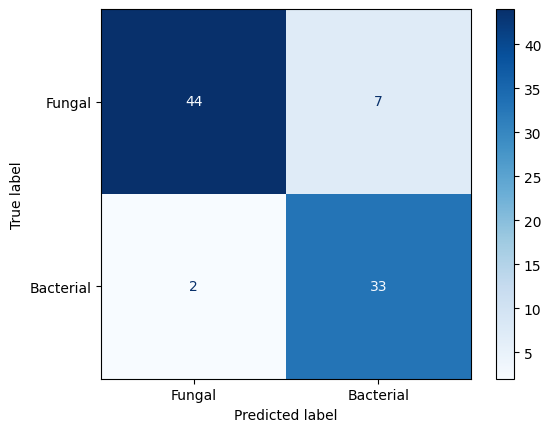

In [13]:
cm_displayed = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fungal", "Bacterial"])

# Plot the confusion matrix
cm_displayed.plot(cmap=plt.cm.Blues)

#plt.savefig('cm_multitask_firstgo.png')

plt.show()